In [13]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
import tensorflow.keras as tfk
from sklearn.utils import resample
import matplotlib.pyplot as plt


In [3]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [4]:
# Set the directory paths
base_dir = os.getcwd()  # Assuming the current directory contains the 'healthy' and 'unhealthy' folders
healthy_dir = os.path.join(base_dir, 'healthy')
unhealthy_dir = os.path.join(base_dir, 'unhealthy')

# Initialize the data generators
datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)  # Using 20% of the data for validation

# Prepare iterators
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary',
    subset='training'  # Set as training data
)

validation_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Set as validation data
)


Found 4002 images belonging to 2 classes.
Found 999 images belonging to 2 classes.


In [5]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
for layer in base_model.layers[:140]:
    layer.trainable = False

In [6]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', f1_m, precision_m, recall_m])


In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)


In [8]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=100,
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/100
125/125 [==============================] - ETA: 0s - loss: 0.8806 - accuracy: 0.7519 - f1_m: 0.6588 - precision_m: 0.6910 - recall_m: 0.6616
Epoch 1: val_loss improved from inf to 24.90084, saving model to best_model.h5


c:\Users\gusta\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 178s 1s/step - loss: 0.8806 - accuracy: 0.7519 - f1_m: 0.6588 - precision_m: 0.6910 - recall_m: 0.6616 - val_loss: 24.9008 - val_accuracy: 0.7893 - val_f1_m: 0.6426 - val_precision_m: 0.8764 - val_recall_m: 0.5227
Epoch 2/100
125/125 [==============================] - ETA: 0s - loss: 0.2878 - accuracy: 0.8960 - f1_m: 0.8540 - precision_m: 0.8821 - recall_m: 0.8472
Epoch 2: val_loss improved from 24.90084 to 0.61042, saving model to best_model.h5
125/125 [==============================] - 185s 1s/step - loss: 0.2878 - accuracy: 0.8960 - f1_m: 0.8540 - precision_m: 0.8821 - recall_m: 0.8472 - val_loss: 0.6104 - val_accuracy: 0.8175 - val_f1_m: 0.7378 - val_precision_m: 0.8066 - val_recall_m: 0.6884
Epoch 3/100
125/125 [==============================] - ETA: 0s - loss: 0.1959 - accuracy: 0.9395 - f1_m: 0.9105 - precision_m: 0.9230 - recall_m: 0.9080
Epoch 3: val_loss did not improve from 0.61042
125/125 [==============================] - 189s 2s/

In [11]:
# Evaluate the model on the validation set
eval_result = model.evaluate(validation_generator)
print(f"Validation Loss: {eval_result[0]}, Validation Accuracy: {eval_result[1]}")

32/32 [==============================] - 12s 388ms/step - loss: 0.6126 - accuracy: 0.8158 - f1_m: 0.7254 - precision_m: 0.8055 - recall_m: 0.6766
Validation Loss: 0.6125877499580383, Validation Accuracy: 0.815815806388855


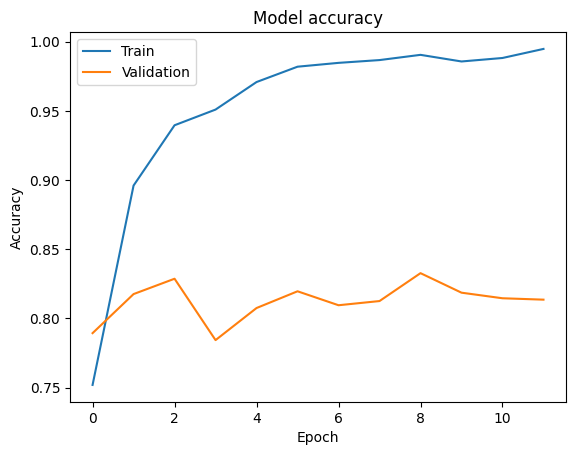

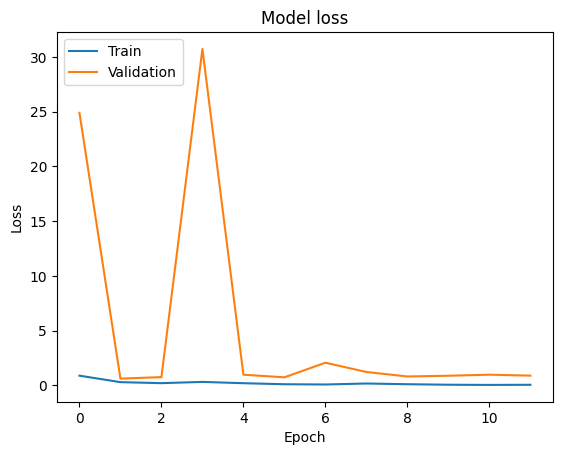

In [12]:
# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [15]:
# Fine tune the model
model.trainable = True

early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)


# Recompiling the model
model.compile(optimizer=tfk.optimizers.Adam(1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy', f1_m, precision_m, recall_m])

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=6,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/6
125/125 [==============================] - ETA: 0s - loss: 0.0882 - accuracy: 0.9783 - f1_m: 0.9619 - precision_m: 0.9702 - recall_m: 0.9568
Epoch 1: val_loss did not improve from 0.38551
125/125 [==============================] - 343s 3s/step - loss: 0.0882 - accuracy: 0.9783 - f1_m: 0.9619 - precision_m: 0.9702 - recall_m: 0.9568 - val_loss: 0.5171 - val_accuracy: 0.8377 - val_f1_m: 0.7589 - val_precision_m: 0.8366 - val_recall_m: 0.7061
Epoch 2/6
125/125 [==============================] - ETA: 0s - loss: 0.0530 - accuracy: 0.9882 - f1_m: 0.9761 - precision_m: 0.9793 - recall_m: 0.9745
Epoch 2: val_loss did not improve from 0.38551
125/125 [==============================] - 328s 3s/step - loss: 0.0530 - accuracy: 0.9882 - f1_m: 0.9761 - precision_m: 0.9793 - recall_m: 0.9745 - val_loss: 0.4805 - val_accuracy: 0.8397 - val_f1_m: 0.7604 - val_precision_m: 0.8348 - val_recall_m: 0.7093
Epoch 3/6
125/125 [==============================] - ETA: 0s - loss: 0.0408 - accuracy: 0.99

In [16]:
# Save the model
model.save('SubmissionModel')

INFO:tensorflow:Assets written to: SubmissionModel\assets


INFO:tensorflow:Assets written to: SubmissionModel\assets


In [1]:
out = model.predict(validation_generator)

print(tf.argmax(out, axis=-1))

NameError: name 'model' is not defined